# Game Score Notebook

## References and Links

### All of these metrics were created and scaled to approximate a corilation to Points in a game. 
Inspired by this article I found about a metric that was developed in 2016, Dom Luszczyszyn which is intended to provide a single number that approximates a player’s performance in a given game. In that original story, he included the formula for the metric and how he arrived at it, so it’s inspired various adaptations since then.
https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/

The stats I used are goals, primary assists, secondary assists, shots on goal, blocked shots, penalty differential, faceoffs, 5-on-5 corsi differential, 5-on-5 goal differential.

Player Game Score = (0.75 * G) + (0.7 * A1) + (0.55 * A2) + (0.075 * SOG) + (0.05 * BLK) + (0.15 * PD) – (0.15 * PT) + (0.01 * FOW) – (0.01 * FOL) + (0.05 * CF) – (0.05 * CA) + (0.15 * GF) – (0.15* GA)



## Adjusted / Simplified
- found on the blog frshice.substack.com
- Bailey Johnson created her simplified version to work on college hockey data because not all of the factors (specifically the defensive portion of the Corsi Metric) is not track or is not available for NCAA games

### Original
For clarity’s sake, this was my original formula after removing stats I didn’t have access to from Dom’s: Player Game Score = (0.75*G)+(0.7*A1)+(0.55*A2)+(0.075*SOG)+(0.05*BLK)+(0.01*FOW)–(0.01*FOL)+(0.15*GF)–(0.15*GA)

### Bailey Final
- I also followed Shawn’s method from his NWHL game score work and used league-wide power-play percentage to weight the impact of taking a penalty.

- Dom scaled his formula down 75% to make the game scores roughly equivalent to points so people would be familiar with what the game score represented, and I kept to that methodology here because I used some of the same weights he did. Also keep in mind that the goals for and goals against are just goals scored at even strength — it does not include special teams, empty-net or extra-attacker goals.

Player Game Score = (G*0.75)+(A1*0.715)+(A2*0.555)+(SOG*0.075)+(BLK*0.05)+(FOW*0.01)-(FOL*0.01)+(GF*0.15)-(GA*0.15)-(PNT*0.138)

### PNT*.138
- FROM SOURCE: I took the frequency of powerplay goals to penalties, otherwise known as PP%. (https://hockey-graphs.com/2018/03/22/an-introduction-to-nwhl-game-score/)
- this is her attempt to account for penalties - CHN NCAA stats don't include penalties drawn 
- PNT is penalties taken so I will want to grab the penalty incidents, not the minutes. 
- The 0.138 factor come from the league's power play percentage 
    - Want to use a static figure like overall average PP % for entire NCAA 
        - could update it to be dynamic and create a new average every time the data is called

        - IDEA: Could create a custom factor for each team in each game 
            - teams power play effectiveness can vary greatly, as can a teams PK%
            - Take the each teams previous success on PP or even on both PP and PK
            - Compare to NCAA wide average
            - get a factor that could be used and could scale the danger of taking a penalty based on how good the opponent is on PP or how poor your team is on PP


In [25]:
## Blocking out the Game Score formula

#### METRIC Formula
# 
# METRIC = SCORE [ (Goals*0.75) + (Assist1*0.715) + (Assist2*0.555) ] 
#               + SHOTS [ (Shot_On_Net*0.075) + (Shots_Off_Net*0.075) - (Shots_Blocked*0.075) ]
#               + FACEOFFS [ (Faceoff_Wins*0.01) - (Faceoff_Losses*0.01) ]
#               + TEAM [ (Goals_For_Team*0.15) + (Goals_Against_Team*0.15) ]
#               -  [ (Penalties_Taken * Overall_PP_Success_Rate) ]

# Map to each factor in the Game_Stats Database

## Calculating a Game Score for each player on each team for each game
Each Game has a unique Game_ID column in every relevant table

scoring_summary table
    Goals - in scoring_summary - count of player's name in Player Column
    Assist1 - scoring_summary - Count in Assist1
    Assist2 - scoring_summary - Count in Assist2


abdvanced_metrics_combined table
    Shots_On_Net -  - EVEN_Saved + EVEN_Goals
    Shots_Off_Net = EVENE_Miss
    Shots_Blocked = EVEN_Block

    Defensive_Blocks = D_Blocks

player_stats
    Faceoff_Wins = FO_W
    Faceoff_Loses = FO_L

### This takes into account team goals for and goals against but only counts Even strength goals in close games (+/- 1)
- can get it from the advanced metrics combined

advanced_metrics_
    Goals_For_Team = SUM of CLOSE_Goals grouped by Team -NOTE
#### NOTE- need to filter out any rows in the advanced_metrics_combined with player = 'TOTAL'
    Goals_Against_Team - do the same but for the opposing team - if Game_ID matches and Team =/= the player's team

penalty_summary
    Penalties_Taken = Count of Player's name in 



In [26]:

import sqlite3
import pandas as pd
import numpy as np

import sqlite3
###########################
##   CURRENT SEASON - 2023 ###

db_path ='../data/db//NOV_11_YTD_Game_Stats.db'


##############################
##   SET SEASON TO PULL   ###`
# 
# db_path ='../data/db/2022_Game_stats_Cleaned.db'


#
##############################

conn = sqlite3.connect(db_path)

# Connect to the provided database

cursor = conn.cursor()

# Retrieve the list of tables in the database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [table[0] for table in tables]

# Retrieve the columns from each table to get a better understanding of the data structure
table_columns = {}
for table in tables:
    columns = cursor.execute(f"PRAGMA table_info({table});").fetchall()
    table_columns[table] = [column[1] for column in columns]

# table_columns


# Create an empty dataframe to store the data
compiled_df = pd.DataFrame()

## Get Shot Data

In [27]:
# Update the code to clean the 'advanced_metrics_combined' table by removing 'TOTAL' rows

# Load the 'advanced_metrics_combined' table into a DataFrame excluding 'TOTAL' rows
df_amc = pd.read_sql("SELECT * FROM advanced_metrics WHERE player != 'TOTAL'", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['EVEN_Saved', 'EVEN_Goals', 'EVEN_Miss', 'EVEN_Block', 'D_Blocks']
for col in columns_to_convert:
    df_amc[col] = pd.to_numeric(df_amc[col].replace('', '0'))

# Calculate required columns
df_amc['Shots_On_Net'] = df_amc['EVEN_Saved'] + df_amc['EVEN_Goals']
df_amc['Shots_Off_Net'] = df_amc['EVEN_Miss']
df_amc['Shots_Blocked'] = df_amc['EVEN_Block']
df_amc['Defensive_Blocks'] = df_amc['D_Blocks']

# Create a DataFrame with only the desired columns
# shots_df = df_amc[['Player', 'Team', 'Shots_On_Net', 'Shots_Off_Net', 'Shots_Blocked', 'Defensive_Blocks', 'Game_ID']]

# Create a DataFrame with only the desired columns - LEAVE OFF TEAM AND TRY TO ADD IT LATER
shots_df = df_amc[['Player', 'Team', 'Shots_On_Net', 'Shots_Off_Net', 'Shots_Blocked', 'Defensive_Blocks', 'Game_ID']]

# Display the column names of the shots_df
shots_df.columns

shots_df.head(25)

# Merge into the compiled_df
compiled_df = shots_df.copy()

# # Team Name Split
# team_name_split = compiled_df['Game_ID'].str.split('-').str[-2:]
# compiled_df['Temp_Team_1'] = team_name_split.str[0]
# compiled_df['Temp_Team_2'] = team_name_split.str[1]

# # If Home/Away is Away Then Team is Temp_Team_1
# # If Home/Away is Home Then Team is Temp_Team_2
# compiled_df['Team'] = np.where(compiled_df['Home/Away'] == 'Away', compiled_df['Temp_Team_1'], compiled_df['Temp_Team_2'])

# # Drop Temp Columns
# compiled_df.drop(['Temp_Team_1', 'Temp_Team_2'], axis=1, inplace=True)


# compiled_df.head(45)

## Output a CSV of the compiled_df for manual check
# compiled_df.to_csv('../TEMP/compiled_df_1.csv', index=False)


# Use Master_Roster To Get Player to Team Mapping

In [28]:
# ## See column names from master_roster table
# cursor.execute("SELECT * FROM master_roster")
# col_names = [description[0] for description in cursor.description]
# col_names

In [29]:
# # Extracting all the player names from the master_roster table
# all_player_names_master_roster = set(pd.read_sql("SELECT Clean_Name FROM master_roster", conn)['Clean_Name'])

# # Finding the intersection of player names between compiled_df and master_roster
# common_names = set(compiled_df['Player']).intersection(all_player_names_master_roster)

# # Take out those annoying character if there are any
# # Replace non-breaking spaces with regular spaces in the player names
# compiled_df['Player'] = compiled_df['Player'].str.replace(u'\xa0', u' ')


# # Finding names in compiled_df that are not in master_roster
# missing_names = set(compiled_df['Player']) - all_player_names_master_roster

# len(common_names), len(missing_names), list(missing_names)[:10]  # Displaying the first 10 missing names


In [30]:
# # Create a DataFrame with the missing names
# missing_names_df = compiled_df[compiled_df['Player'].isin(missing_names)]

# missing_names_df.head(25)

# ## unique Game_IDs in the missing_names_df
# missing_names_df['Game_ID'].nunique()

In [31]:
## How many Nan Values are there in the Team Column?
compiled_df['Team'].isna().sum()

# Value Count of the Team Column
# compiled_df['Team'].value_counts()

0

# Get Goal, Assist1 and Assist2
- Working

In [32]:
# Separately calculate Goals, Assist1, and Assist2

# Goals
goals_df = pd.read_sql("""
SELECT 
    Player,
    Game_ID,
    COUNT(Player) AS Goals
FROM 
    scoring_summary
GROUP BY 
    Player, Game_ID;
""", conn)

# Assist1
assist1_df = pd.read_sql("""
SELECT 
    Assist1 AS Player,
    Game_ID,
    COUNT(Assist1) AS Assist1
FROM 
    scoring_summary
WHERE 
    Assist1 IS NOT NULL AND Assist1 != ''
GROUP BY 
    Assist1, Game_ID;
""", conn)

# Assist2
assist2_df = pd.read_sql("""
SELECT 
    Assist2 AS Player,
    Game_ID,
    COUNT(Assist2) AS Assist2
FROM 
    scoring_summary
WHERE 
    Assist2 IS NOT NULL AND Assist2 != ''
GROUP BY 
    Assist2, Game_ID;
""", conn)


# goals_df.head(25)
# Merge the dataframes together
merged_df = goals_df.merge(assist1_df, on=['Player', 'Game_ID'], how='outer')
merged_df = merged_df.merge(assist2_df, on=['Player', 'Game_ID'], how='outer')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Convert columns to int
merged_df['Goals'] = merged_df['Goals'].astype(int)
merged_df['Assist1'] = merged_df['Assist1'].astype(int)
merged_df['Assist2'] = merged_df['Assist2'].astype(int)

# # Sort by Player
goal_assist_df = merged_df.sort_values(by=['Player'])

# # Display the first few rows
goal_assist_df.head(20)



# # Merge the Goal and Assist info into the compiled_df join left
# compiled_df = pd.merge(compiled_df, goal_assist_df, on=['Player', 'Game_ID'], how='outer')


compiled_df.sample(10)
compiled_df.info()



# # Histogram of the compiled_df
# compiled_df.hist()

compiled_df.to_csv('../TEMP/compiled_df_2.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11335 entries, 0 to 11334
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Player            11335 non-null  object
 1   Team              11335 non-null  object
 2   Shots_On_Net      11335 non-null  int64 
 3   Shots_Off_Net     11335 non-null  int64 
 4   Shots_Blocked     11335 non-null  int64 
 5   Defensive_Blocks  11335 non-null  int64 
 6   Game_ID           11335 non-null  object
dtypes: int64(4), object(3)
memory usage: 620.0+ KB


In [33]:
## Value count of Teams
compiled_df['Team'].value_counts()

# How many Nan Values are there in the Team Column?
compiled_df['Team'].isna().sum()

0

In [34]:
# Replace non-breaking spaces with regular spaces in the Player column of compiled_df
compiled_df['Player'] = compiled_df['Player'].str.replace('\xa0', ' ')

# Merge the dataframes again
new_merged_df = pd.merge(compiled_df, goal_assist_df, on=['Player', 'Game_ID'], how='left')

# Fill NaN values with 0 for the Goals, Assist1, and Assist2 columns
new_merged_df[['Goals', 'Assist1', 'Assist2']] = new_merged_df[['Goals', 'Assist1', 'Assist2']].fillna(0).astype(int)

# Display the first few rows of the merged dataframe
merged_df.head()

new_merged_df.info()

# RENAME BACK TO COMPILED_DF FOR USE LATER
compiled_df = new_merged_df.copy()

# compiled_df.to_csv('../TEMP/compiled_df_3.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11335 entries, 0 to 11334
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Player            11335 non-null  object
 1   Team              11335 non-null  object
 2   Shots_On_Net      11335 non-null  int64 
 3   Shots_Off_Net     11335 non-null  int64 
 4   Shots_Blocked     11335 non-null  int64 
 5   Defensive_Blocks  11335 non-null  int64 
 6   Game_ID           11335 non-null  object
 7   Goals             11335 non-null  int32 
 8   Assist1           11335 non-null  int32 
 9   Assist2           11335 non-null  int32 
dtypes: int32(3), int64(4), object(3)
memory usage: 752.8+ KB


In [35]:
# # new_merged_df['Goals'].hist()

# new_merged_df.head(20)

# compiled_df.head(20)
# Value Counts of Teams
# compiled_df['Team'].value_counts()

# How many Nan values are in the Team column?
# compiled_df['Team'].isna().sum()

# 

In [36]:
### OUTPUT CSVS

# # Save the compiled_df to a csv
# compiled_df.to_csv('../TEMP/PRELIM_compiled_df.csv', index=False)

# # Save the goal_assist_df to a csv
# goal_assist_df.to_csv('../TEMP/PRELIM_goal_assist_df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Player            11991 non-null  object  
 1   Team              11335 non-null  object  
 2   Shots_On_Net      11335 non-null  float64 
 3   Shots_Off_Net     11335 non-null  float64 
 4   Shots_Blocked     11335 non-null  float64 
 5   Defensive_Blocks  11335 non-null  float64 
 6   Game_ID           11991 non-null  object  
 7   Goals             11335 non-null  float64 
 8   Assist1           11335 non-null  float64 
 9   Assist2           11335 non-null  float64 
 10  Faceoff_Wins      3606 non-null   float64 
 11  Faceoff_Losses    3606 non-null   float64 
 12  _merge            11991 non-null  category
dtypes: category(1), float64(9), object(3)
memory usage: 1.1+ MB


Team
Connecticut       227
St. Thomas        227
Michigan          227
Michigan State    227
Air Force         226
                 ... 
Brown             111
Dartmouth         110
Harvard            95
Yale               93
Princeton          76
Name: count, Length: 64, dtype: int64

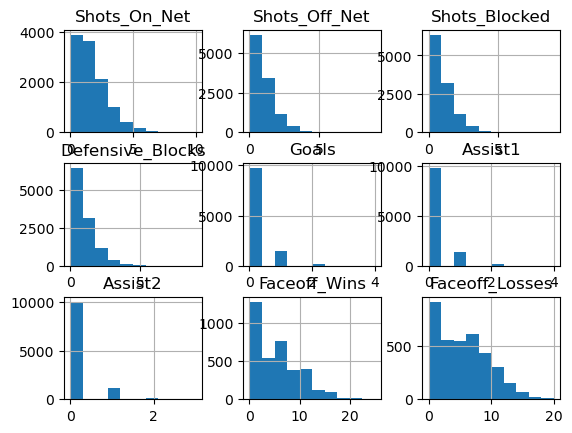

In [37]:
# Calculate Faceoff Metrics for each player in each game

query_faceoff_metrics = """
SELECT 
    Player,
    Game_ID,
    FOW AS Faceoff_Wins,
    FOL AS Faceoff_Losses
FROM 
    player_stats;
"""

# Create a DataFrame with the results



faceoff_metrics_data = cursor.execute(query_faceoff_metrics).fetchall()

# Preview the first few rows of the result
faceoff_metrics_data[:5]

# Create DataFrame with the results
faceoff_metrics_df = pd.DataFrame(faceoff_metrics_data, columns=['Player', 'Game_ID', 'Faceoff_Wins', 'Faceoff_Losses'])

# Take out those annoying character if there are any
# Replace non-breaking spaces with regular spaces in the Player column of compiled_df
faceoff_metrics_df['Player'] = faceoff_metrics_df['Player'].str.replace('\xa0', ' ')

# Replace non-breaking spaces with regular spaces in the Player column of compiled_df
compiled_df['Team'] = compiled_df['Team'].str.replace('\xa0', ' ')

# Drop old indicator column to make way for new one
# compiled_df = compiled_df.drop(columns=['_merge'])
compiled_df = compiled_df.merge(faceoff_metrics_df, on=['Player', 'Game_ID'], how='outer', indicator=True)

# Histogram of the compiled_df
compiled_df.hist()

compiled_df.info()
compiled_df.head(25)

# compiled_df.columns

compiled_df['Team'].value_counts()

# compiled_df.to_csv('../TEMP/compiled_df_4.csv', index=False)

# compiled_df['Team'].isna().sum()

### Overall PP Success

In [38]:
### Find the Overall Power Play Success rate for the entire database

# Count the total number of Power Play (PP) goals from the scoring_summary table.
pp_goals_count = cursor.execute("SELECT COUNT(*) FROM scoring_summary WHERE PP != '';").fetchone()[0]

# Count the total number of Power Plays from the penalty_summary table.
total_pp_count = cursor.execute("SELECT COUNT(*) FROM penalty_summary;").fetchone()[0]

# Calculate the Power Play success rate.
pp_success_rate = pp_goals_count / total_pp_count


## OVERALL NCAA WIDE POWER PLAY SUCCESS RATE TO USE IN FACTOR
pp_success_rate


0.2549945513984744

In [39]:
# even_strength_goals_refined_df.shape

# Drop indicator column before new merge
compiled_df = compiled_df.drop(columns=['_merge'])





# # Save the compiled_df to a csv
# compiled_df.to_csv('../TEMP/NEW_PRELIM_compiled_df.csv', index=False)

compiled_df['Team'].value_counts()

compiled_df['Team'].isna().sum()

# compiled_df.sample(20)

656

# Team Goals Component

In [40]:
## Get the Team_Goals_For and Team_Goals_Against for each player in each game
## Only include EVEN_STRENGTH goals
## Access the EVEN_STRENGTH goals advanced_metrics_combined table from the TOTAL row from each team and apply it to each player in the game
## EVEN Strength goals for the team should be stored in 'Goals_For_Team' and the opponent's EVEN Strength goals should be stored in 'Goals_Against_Team'

# Extracting EVEN_STRENGTH goals (where PP column is blank) for each team
even_strength_goals_query_refined = """
SELECT 
    Game_ID,
    Team,
    COUNT(*) AS Goals_For_Team
FROM 
    scoring_summary
WHERE 
    PP = ''
GROUP BY 
    Game_ID, Team
"""

even_strength_goals_refined_df = pd.read_sql(even_strength_goals_query_refined, conn)

# Correct the values in the Team column so we can effectively join the dataframes

# Create a new column for the row number grouped by Game_ID
even_strength_goals_refined_df['row_number'] = even_strength_goals_refined_df.groupby('Game_ID').cumcount() + 1

# Function to assign the correct team name based on the row number
def assign_team_name(row):
    return row['Team_1'] if row['row_number'] == 1 else row['Team_2']

# Splitting the Game_ID column again to extract team names
team_names_split = even_strength_goals_refined_df['Game_ID'].str.split('-').str[-2:]
even_strength_goals_refined_df['Team_1'] = team_names_split.str[0]
even_strength_goals_refined_df['Team_2'] = team_names_split.str[1]

# Applying the function to assign the correct team name
even_strength_goals_refined_df['Team'] = even_strength_goals_refined_df.apply(assign_team_name, axis=1)

# Dropping the extra columns again
even_strength_goals_refined_df.drop(columns=['Team_1', 'Team_2', 'row_number'], inplace=True)

# Creating a new column 'Opponent_Goals' which will be used to determine the goals against each team
even_strength_goals_refined_df = even_strength_goals_refined_df.merge(
    even_strength_goals_refined_df[['Game_ID', 'Team', 'Goals_For_Team']], 
    on='Game_ID',
    suffixes=('', '_Opponent')
)

# Filtering out rows where Team is the same as the opponent team
even_strength_goals_refined_df = even_strength_goals_refined_df[even_strength_goals_refined_df['Team'] != even_strength_goals_refined_df['Team_Opponent']]

# Assigning the 'Goals_For_Team_Opponent' to a new column 'Goals_Against_Team'
even_strength_goals_refined_df['Goals_Against_Team'] = even_strength_goals_refined_df['Goals_For_Team_Opponent']

# Dropping unnecessary columns
even_strength_goals_refined_df.drop(columns=['Team_Opponent', 'Goals_For_Team_Opponent'], inplace=True)

even_strength_goals_refined_df.head(25)

# Take out those annoying character if there are any
# Replace non-breaking spaces with regular spaces in the Player column of compiled_df
even_strength_goals_refined_df['Team'] = even_strength_goals_refined_df['Team'].str.replace('\xa0', ' ')

## SAVE A CSV 
# even_strength_goals_refined_df.to_csv('../TEMP/NEW_PRELIM_even_strength_goals_refined_df.csv', index=False)

# # Displaying the dataframe with the newly computed 'Goals_Against_Team' values
even_strength_goals_refined_df.sample(25)


# # print(compiled_df.shape)


,Game_ID,Team,Goals_For_Team,Goals_Against_Team
546,2023-10-28-RIT-Holy Cross,RIT,1,1
20,2023-10-07-Denver-Alaska,Denver,2,5
33,2023-10-07-Mass.-Lowell-Alaska-Anchorage,Anchorage,1,2
107,2023-10-13-Alaska-Michigan Tech,Michigan Tech,1,2
520,2023-10-28-Lindenwood-Michigan,Michigan,2,1
794,2023-11-10-Mercyhurst-RIT,Mercyhurst,2,4
672,2023-11-04-Connecticut-Vermont,Connecticut,2,2
597,2023-11-03-Mercyhurst-Bowling Green,Mercyhurst,2,2
542,2023-10-28-Niagara-Sacred Heart,Sacred Heart,1,1
713,2023-11-04-Princeton-Dartmouth,Princeton,3,1


In [41]:
# Merge the dataframes on Game_ID and Team
merged_df_new = pd.merge(compiled_df, even_strength_goals_refined_df, on=['Game_ID', 'Team'], how='left')

# Display the first few rows of the merged dataframe
merged_df_new.head(25)

# merged_df_new.info()
# Output csv for check
# merged_df_new.to_csv('../TEMP/11_NEW_PRELIM_merged_df_new.csv', index=False)

,Player,Team,Shots_On_Net,Shots_Off_Net,Shots_Blocked,Defensive_Blocks,Game_ID,Goals,Assist1,Assist2,Faceoff_Wins,Faceoff_Losses,Goals_For_Team,Goals_Against_Team
0,Harrison Roy,Lake Superior,1.0,2.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,1.0,0.0,0.0,4.0,15.0,1.0,4.0
1,Tyler Williams,Lake Superior,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,1.0,0.0,0.0,NaN,NaN,1.0,4.0
2,Artyom Borshyov,Lake Superior,2.0,1.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
3,John Herrington,Lake Superior,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
4,Sasha Teleguine,Lake Superior,0.0,1.0,2.0,2.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
5,Grant Hindman,Lake Superior,2.0,1.0,0.0,2.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
6,Nate Schweitzer,Lake Superior,3.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
7,Reagan Milburn,Lake Superior,1.0,1.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,NaN,NaN,1.0,4.0
8,Carter Batchelder,Lake Superior,2.0,0.0,0.0,1.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,1.0,3.0,3.0,1.0,4.0
9,Evan Bushy,Lake Superior,2.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0,0.0,1.0,1.0,4.0


New Shape: (11991, 12)


Team
Michigan          227
Michigan State    227
Connecticut       227
St. Thomas        227
Air Force         226
                 ... 
Dartmouth         110
Harvard            95
Yale               93
Princeton          76
Mass.               2
Name: count, Length: 65, dtype: int64

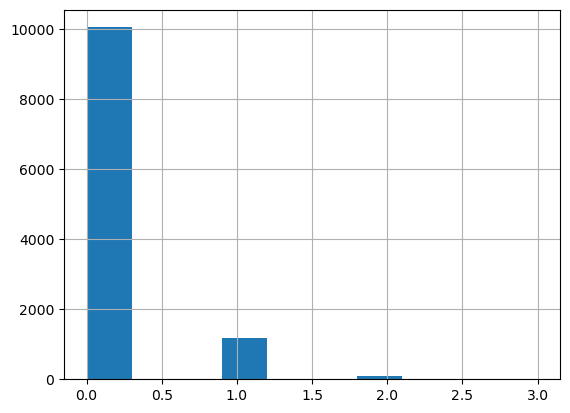

In [42]:

# Convert columns to int
int_cols = [ 'Shots_On_Net', 'Shots_Off_Net', 'Shots_Blocked',
       'Defensive_Blocks',  'Goals', 'Assist1', 'Assist2',
       'Faceoff_Wins', 'Faceoff_Losses', 'Goals_For_Team',
       'Goals_Against_Team']

# for col in int_cols:
#     compiled_df[col] = compiled_df[col].astype(int)



print(f'New Shape: {compiled_df.shape}')

####
# # Merge into the compiled_df
compiled_df = compiled_df.merge(even_strength_goals_refined_df, on=['Game_ID', 'Team'], how='outer', indicator=True)

compiled_df.columns

# compiled_df['Goals'].hist()
# compiled_df['Assist1'].hist()
compiled_df['Assist2'].hist()

compiled_df.sample(25)

# Team value count
compiled_df['Team'].value_counts()



In [43]:
# SHow just the rows where the Goals_Against_Team is NaN
trouble_df = merged_df_new[merged_df_new['Goals_Against_Team'].isna()]

# Value Counts of Teams
trouble_df['Team'].value_counts()

# I think what is going on is thes are instanced when the player was not on the roster the day of the game?

## Do any of these have values in Goals or Assists?
trouble_df[trouble_df['Goals'] > 0]

trouble_df[trouble_df['Assist1'] > 0]

## Could be games when no even strength goals were scored - That must be it. fill with 0
merged_df_new['Goals_Against_Team'] = merged_df_new['Goals_Against_Team'].fillna(0)
# Same for Goals_For_Team
merged_df_new['Goals_For_Team'] = merged_df_new['Goals_For_Team'].fillna(0)

In [44]:
# merged_df_new.hist()

# merged_df_new.info()

# Output csv for check
# merged_df_new.to_csv('../TEMP/NEW_PRELIM_merged_df_new.csv', index=False)

In [45]:
# # Joining the dataframe with itself to compute EVEN_STRENGTH goals against each team
# team_goals_refined_df = even_strength_goals_refined_df.merge(
#     even_strength_goals_refined_df, on='Game_ID', suffixes=('', '_Opponent')
# )

# # Filtering out rows where Team is the same as the opponent team
# team_goals_refined_df = team_goals_refined_df[team_goals_refined_df['Team'] != team_goals_refined_df['Team_Opponent']]

# # Dropping unnecessary columns and renaming for clarity
# team_goals_refined_df = team_goals_refined_df[['Game_ID', 'Team', 'Goals_For_Team', 'Goals_For_Team_Opponent']]
# team_goals_refined_df = team_goals_refined_df.rename(columns={'Goals_For_Team_Opponent': 'Goals_Against_Team'})

# # Joining with advanced_metrics_combined to assign the values to each player
# player_goals_refined_df = player_goals_df.merge(team_goals_refined_df, on=['Game_ID', 'Team'], how='left')

# # Display the first few rows of the resulting dataframe
# player_goals_refined_df[['Player', 'Game_ID', 'Team', 'Goals_For_Team', 'Goals_Against_Team']].head(25)


# Penalty Component

In [46]:
## Penalty Component

# Count the number of penalties taken by each player in each game
penalty_count_query = """
SELECT
    Game_ID,
    Player,
    COUNT(*) AS Penalties_Taken
FROM
    penalty_summary
WHERE
    Player != 'TOTAL'
GROUP BY
    Game_ID, Player;
"""

## Rename the new version of the df back to this name to use later

compiled_df = merged_df_new.copy()


# Create a DataFrame with the results
penalty_count_df = pd.read_sql(penalty_count_query, conn)

# Preview the first few rows of the result
penalty_count_df.head()

# penalty_count_df['Penalties_Taken'].hist()

# Convert to int
penalty_count_df['Penalties_Taken'] = penalty_count_df['Penalties_Taken'].astype(int)

# penalty_count_df.describe()

# merge it into the compiled_df
compiled_df = compiled_df.merge(penalty_count_df, on=['Player', 'Game_ID'], how='left')

# Fill NaN values in 'Penalties_Taken' with 0
compiled_df['Penalties_Taken'].fillna(0, inplace=True)

# compiled_df.head(25)


# compiled_df.hist()

compiled_df.columns

# Output CSV
# compiled_df.to_csv('../TEMP/GAME_SCORE_compiled_df.csv', index=False)


compiled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player              11991 non-null  object 
 1   Team                11335 non-null  object 
 2   Shots_On_Net        11335 non-null  float64
 3   Shots_Off_Net       11335 non-null  float64
 4   Shots_Blocked       11335 non-null  float64
 5   Defensive_Blocks    11335 non-null  float64
 6   Game_ID             11991 non-null  object 
 7   Goals               11335 non-null  float64
 8   Assist1             11335 non-null  float64
 9   Assist2             11335 non-null  float64
 10  Faceoff_Wins        3606 non-null   float64
 11  Faceoff_Losses      3606 non-null   float64
 12  Goals_For_Team      11991 non-null  float64
 13  Goals_Against_Team  11991 non-null  float64
 14  Penalties_Taken     11991 non-null  float64
dtypes: float64(12), object(3)
memory usage: 1.4+ MB


## Notes to Change Metric
### Add an element for shots, goals, ect in close games.
- we have the shot info broken into close games. should give a bonus for CLOSE goals and shots 

- it also seems stupid to not do anything with power play. I am looking at game where one team did not miss the goal when shooting on the power play. that kind of efficency should be worth something to the player score

- change factor for face offs. .01 is pretty stupid. if we go by the face off per goal what would the factor be? more like 1 goal every 10-15 face offs

- Should there be a bonus for unassisted goals? -it should be possible to seperate those out and add a bonus






In [49]:
# Fill NaN values in 'Penalties_Taken' with 0
compiled_df['Penalties_Taken'].fillna(0, inplace=True)

# Calculate each component of the game score formula
player_goals_refined_df = compiled_df.copy()

# SCORE Component
player_goals_refined_df['SCORE'] = (player_goals_refined_df['Goals'] * 0.75) + \
                                  (player_goals_refined_df['Assist1'] * 0.715) + \
                                  (player_goals_refined_df['Assist2'] * 0.555)

# SHOTS Component
player_goals_refined_df['SHOTS'] = (player_goals_refined_df['Shots_On_Net'] * 0.075) + \
                                  (player_goals_refined_df['Shots_Off_Net'] * 0.075) - \
                                  (player_goals_refined_df['Shots_Blocked'] * 0.075)

# FACEOFFS Component
player_goals_refined_df['FACEOFFS'] = (player_goals_refined_df['Faceoff_Wins'] * 0.01) - \
                                     (player_goals_refined_df['Faceoff_Losses'] * 0.01)
# Fill NaN values in 'Faceoff_Wins' and 'Faceoff_Losses' with 0
player_goals_refined_df['FACEOFFS'].fillna(0, inplace=True)


# TEAM Component
player_goals_refined_df['TEAM'] = (player_goals_refined_df['Goals_For_Team'] * 0.15) - \
                                 (player_goals_refined_df['Goals_Against_Team'] * 0.15)
# Fill


# PENALTIES Component -  Negative because it is a penalty
player_goals_refined_df['PENALTIES'] = (player_goals_refined_df['Penalties_Taken'] * pp_success_rate) * -1

## Fill all Nan Values with 0
player_goals_refined_df.fillna(0, inplace=True)

# Calculate the overall game score
player_goals_refined_df['Game_Score'] = player_goals_refined_df['SCORE'] + \
                                       player_goals_refined_df['SHOTS'] + \
                                       player_goals_refined_df['FACEOFFS'] + \
                                       player_goals_refined_df['TEAM'] - \
                                       player_goals_refined_df['PENALTIES']

# Display the first few rows of the dataframe with the newly computed 'Game_Score' values
player_goals_refined_df[['Player', 'Game_ID', 'Team', 'Game_Score']].head(25)


## Drop duplicate Rows
player_goals_refined_df = player_goals_refined_df.drop_duplicates()

# Save to CSV
# player_goals_refined_df.to_csv('../TEMP/GAME_SCORE_player_goals_refined_df.csv', index=False)


# Aggrigate the table and get an average based on numbers of game each player has played

PermissionError: [Errno 13] Permission denied: '../TEMP/YTD_csv_dump/All_Players_Game_score.csv'

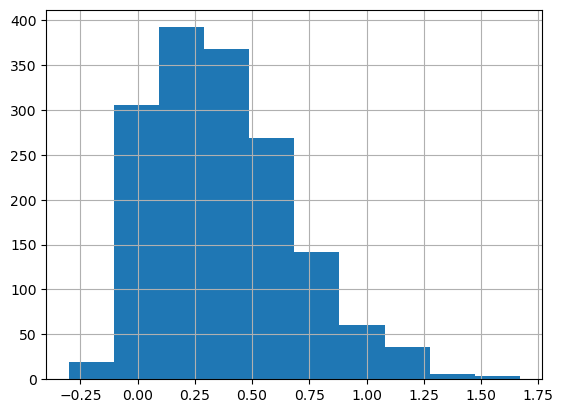

In [48]:
# Aggrigate the player_goals_refined_df and get an average based on numbers of game each player has played
# Add the Game_Score for each player and divide by the number of games played

cumlative_game_score_df = player_goals_refined_df.groupby(['Player', 'Team']).agg({'Game_Score': ['sum', 'count']})

cumlative_game_score_df.columns = ['Game_Score_Sum', 'Games_Played']

# new Column With Average Game Score
cumlative_game_score_df['Average_Game_Score'] = cumlative_game_score_df['Game_Score_Sum'] / cumlative_game_score_df['Games_Played']

# Sort by Average Game Score
cumlative_game_score_df = cumlative_game_score_df.sort_values(by=['Average_Game_Score'], ascending=False)



# Reset Index
cumlative_game_score_df = cumlative_game_score_df.reset_index()

# Display the first few rows of the dataframe with the newly computed 'Game_Score' values
cumlative_game_score_df.head(25)

# Histogram of the Average Game Score
cumlative_game_score_df['Average_Game_Score'].hist()

# Save to CSV
# cumlative_game_score_df.to_csv('../TEMP/YTD_csv_dump/All_Players_Game_score.csv', index=False)









# Pivot the big Game Score Table into individual teams

In [ ]:
# Generate team-specific tables using a pivot table
team_tables = {}

unique_teams = player_goals_refined_df['Team'].unique()

for team in unique_teams:
    team_df = player_goals_refined_df[player_goals_refined_df['Team'] == team]
    pivot_table = team_df.pivot(index='Player', columns='Game_ID', values='Game_Score')
    team_tables[team] = pivot_table


# Print List of Teams
unique_teams


# Fill NaN values with 0
for team in unique_teams:
    team_tables[team] = team_tables[team].fillna(0)

# Display the first team's table as an example
# team_tables[unique_teams[21]].head(40)

### MSU Is In Index Position 21 in this case outputing csv for MSU
# team_tables[unique_teams[21]] = team_tables[unique_teams[21]].fillna(0)
# team_tables[unique_teams[21]].to_csv('../data/Nov_2_MSU_GAME_SCORES.csv')


# msu_df = team_tables[unique_teams[21]].copy()
# msu_df.head()



In [ ]:
## Print Unique Teams
unique_teams


In [ ]:
# ### Find The OSU Index Position and Output CSV

# osu_df = team_tables[unique_teams[16]]

# ## Output CSV
# osu_df.to_csv('../data/Nov_2_Ohio_State_GAME_SCORES.csv')

In [ ]:
# Clean up the column names of all the team tables
# Want to remove:
# - all digits
# - all Dashes
# - the teams name

# Create a dictionary to store the new column names
new_column_names = {}

# Loop through each team table
for team in unique_teams:
    # Create a list to store the new column names
    new_column_names[team] = []
    
    # Loop through each column name
    for column_name in team_tables[team].columns:

        # Remove all digits from the column name
        new_column_name = ''.join([i for i in column_name if not i.isdigit()])
        
        # Remove all dashes from the column name
        new_column_name = new_column_name.replace('-', '')
        
        # Remove the team name from the column name
        new_column_name = new_column_name.replace(str(team), '')
        
        # Add the new column name to the list
        new_column_names[team].append(new_column_name)
    
    # Assign the new column names to the team table
    team_tables[team].columns = new_column_names[team]

    

In [ ]:
## Add the team name to each table
for team in unique_teams:
    team_tables[team]['Team'] = team



In [ ]:
# Add Uniform number from master_roster table to each table

# Extracting the uniform number from the master_roster table
uniform_number_df = pd.read_sql("SELECT No, Clean_Name, Team FROM master_roster", conn)

# Rename Clean_Name to Player to make merge easier
uniform_number_df = uniform_number_df.rename(columns={'Clean_Name': 'Player'})
uniform_number_df['Team'] = uniform_number_df['Team'].astype(str)
for team in unique_teams:
    team_tables[team]['Team'] = team_tables[team]['Team'].astype(str)


# Merge the uniform number into each team table
for team in unique_teams:
    team_tables[team] = team_tables[team].merge(uniform_number_df, on=['Player', 'Team'], how='left')

    # Fill any Nan values with 0
    team_tables[team]['No'] = team_tables[team]['No'].fillna(0)
    # Make sure the uniform number is an int
    team_tables[team]['No'] = team_tables[team]['No'].astype(int)


# team_tables[unique_teams[10]].head(25)

In [ ]:
team_tables[unique_teams[52]].head(25)

# Create an Overall Dataframe, calculate average and sort

In [ ]:

################## NOT WORKING
# # Step 1: Identify the maximum number of games played
# max_games = max(df.shape[1] for df in team_tables.values()) - 1  # -1 for 'Player' column

# # Create a list to store standardized DataFrames
# dfs = []

# for team, df in team_tables.items():
#     # Reset index to get 'Player' as a column, if not already
#     if 'Player' not in df.columns:
#         df = df.reset_index()

#     # Add missing game columns
#     missing_cols = max_games - (df.shape[1] - 1)  # -1 for 'Player' column
#     for i in range(missing_cols):
#         df[f'Game{df.shape[1]}'] = 0

#     # Add 'Team' column
#     df['Team'] = team

#     # Add the standardized DataFrame to the list
#     dfs.append(df)
################## NOT WORKING


# Step 2: Concatenate all standardized DataFrames
all_teams_df = pd.concat(dfs, ignore_index=True)
# Step 2: Calculate Summary Statistics
# Total Points
all_teams_df['Total_Points'] = all_teams_df.drop(['Player', 'Team'], axis=1).sum(axis=1)

# Average PPG
all_teams_df['Avg_PPG'] = all_teams_df.drop(['Player', 'Team', 'Total_Points'], axis=1).apply(lambda row: row[row != 0].mean(), axis=1)

# Function to calculate average for the last N games
def avg_last_games(row, n):
    last_games = row[row != 0][-n:]
    return last_games.mean() if not last_games.empty else 0

# Average for last 5 games
all_teams_df['Avg_Last_5_Games'] = all_teams_df.drop(['Player', 'Team', 'Total_Points', 'Avg_PPG'], axis=1).apply(lambda row: avg_last_games(row, 5), axis=1)

# Average for last 10 games
all_teams_df['Avg_Last_10_Games'] = all_teams_df.drop(['Player', 'Team', 'Total_Points', 'Avg_PPG', 'Avg_Last_5_Games'], axis=1).apply(lambda row: avg_last_games(row, 10), axis=1)




In [ ]:
# Display the resulting DataFrame
print(all_teams_df.head())

all_teams_df.sample(25)

all_teams_df.head(25)

In [ ]:
## Concat all the team tables together to single dataframe
# Concatenate all the team tables together
all_team_tables = pd.concat(team_tables.values())

# Display the first few rows of the concatenated table
all_team_tables.head(25)


## Examine dictionary of team tables
# team_tables

# Output a text file of the team_tables dictionary - for examination
# with open('../TEMP/team_tables.txt', 'w') as file:
#     file.write(str(team_tables))
#     file.close()



# Output Raw CSVs to directory for each team

In [ ]:
## Save each table to a csv with the team name and the season

## Folder to save to
# folder_path = '../TEMP/2022_csv_dump/' # Folder for 2022
folder_path = '../TEMP/YTD_csv_dump/' # Folder for 2023 Year To Date

## Loop through each team and save the csv
for team in unique_teams:
    team_tables[team].to_csv(f'{folder_path}{team}_GAME_SCORES.csv')





# Pivot Tables of Game Scores for Every Player and Every Team should all be stored now if it ran cleanly 

In [ ]:
import plotly.graph_objects as go

## USE MSU AS EXAMPLE
### MSU Is In Index Position 21 in this case outputing csv for MSU
team_tables[unique_teams[21]] = team_tables[unique_teams[21]].fillna(0)
msu_df = team_tables[unique_teams[21]].copy()

csv_df = msu_df.copy()

# Create a basic table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(csv_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[csv_df[col] for col in csv_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.show()


In [ ]:
# Reset the index so that the 'Player' column is included as a regular column
csv_df_reset = csv_df.reset_index()

# Create the table with the updated DataFrame
fig = go.Figure(data=[go.Table(
    header=dict(values=list(csv_df_reset.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[csv_df_reset[col] for col in csv_df_reset.columns],
               fill_color='lavender',
               align='left'))
])

# Note: We're not displaying the figure here due to the environment limitation, 
# but you can use this code in your local setup to see the updated table.
fig.show()

# Return the first few rows of the updated DataFrame for inspection
# csv_df_reset.head()


In [ ]:
# 1. Conditional Formatting: Create a color array for the cells
color_array = [['#D3D3D3' if val == 0 else 'lavender' for val in row] for row in csv_df_reset.values]

# 2. Round Float Values to 3 decimal places
csv_df_rounded = csv_df_reset.round(3)

# Display the first few rows of the rounded DataFrame for inspection
# csv_df_rounded.head()

# 3. Add an Average column
csv_df_rounded['Average'] = csv_df_rounded.iloc[:, 1:].mean(axis=1)

# 4. Sort by Average
csv_df_sorted = csv_df_rounded.sort_values(by='Average', ascending=False)

# Update the color array to include the new column
color_array = [['#D3D3D3' if val == 0 else 'lavender' for val in row] for row in csv_df_sorted.values]

# Display the first few rows of the sorted DataFrame for inspection
csv_df_sorted.head()



In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(csv_df_sorted.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[csv_df_sorted[col] for col in csv_df_sorted.columns],
               fill_color=color_array,
               align='left'))
])
fig.show()


In [ ]:
import numpy as np

# Function to interpolate between three colors
def interpolate_color(value, min_val, max_val):
    # Define the colors for low, mid, and high values
    low_color = np.array([255, 102, 102])  # subtle red
    mid_color = np.array([255, 255, 102])  # yellow
    high_color = np.array([102, 255, 178])  # turquoise green
    
    # Calculate the position of value in the range [min_val, max_val]
    position = (value - min_val) / (max_val - min_val)
    
    # Depending on the position, interpolate between the colors
    if position <= 0.5:  # interpolate between red and yellow
        interp_color = (1 - 2 * position) * low_color + 2 * position * mid_color
    else:  # interpolate between yellow and green
        interp_color = (2 - 2 * position) * mid_color + (2 * position - 1) * high_color
    
    return 'rgb({}, {}, {})'.format(int(interp_color[0]), int(interp_color[1]), int(interp_color[2]))

# Get min and max values for the game columns
min_val = csv_df_sorted.iloc[:, 1:-1].min().min()
max_val = csv_df_sorted.iloc[:, 1:-1].max().max()

# Create a color array for the game columns based on the values
color_array_games = [[interpolate_color(val, min_val, max_val) for val in row[1:-1]] for _, row in csv_df_sorted.iterrows()]

# Combine with the previously defined colors for the Player and Average columns
color_array_combined = [['lavender'] + game_colors + ['lavender'] for game_colors in color_array_games]

# Display the first few rows of the color array for inspection
# color_array_combined[:5]

## Save the color array to a csv
# np.savetxt('../data/Versiob_1.csv', color_array_combined, delimiter=',', fmt='%s')


In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(csv_df_sorted.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[csv_df_sorted[col] for col in csv_df_sorted.columns],
               fill_color=color_array_combined,
               align='left'))
])
fig.show()


In [ ]:
unique_teams

In [ ]:
# Display the first team's table as an example
team_tables[unique_teams[7]].head(40)

ohio_state_df = team_tables[unique_teams[7]].copy()

# Clean Column Headers
# split on - and take the last 2 elements
# ohio_state_df.columns = ohio_state_df.columns.str.split('-').str[-2:]

ohio_state_df.head(25)

# Get a list of the column names
column_names = ohio_state_df.columns.tolist()
# Clean up column names by Removing 'Ohio State' and any digits of dashes
column_names = [name.replace('Ohio State', '') for name in column_names]
column_names = [name.replace('-', '') for name in column_names]
column_names = [name.replace(' ', '') for name in column_names]

# Use regex to remove any digits
import re

column_names = [re.sub(r'\d+', '', name) for name in column_names]



# Replace the column names
ohio_state_df.columns = column_names

ohio_state_df.head(25)

# Save to CSV
# ohio_state_df.to_csv('../TEMP/GAME_SCORE_OHIO_STATE.csv', index=True)

### MSU Is In Index Position 21 in this case outputing csv for MSU
# team_tables[unique_teams[21]] = team_tables[unique_teams[21]].fillna(0)
# team_tables[unique_teams[21]].to_csv('../data/Nov_2_MSU_GAME_SCORES.csv')



# One of THe Michigan Games is Absent From The OSU DATA

In [ ]:
ohio_state_df.head()

In [ ]:
# Create a list of dataframes from the team_tables dictionary
team_tables_list = [team_tables[team] for team in unique_teams]


## Save To an Excell File

In [ ]:
# Assuming unique_teams and team_tables are lists and of the same length
import xlsxwriter

# Create a workbook and add a worksheet for each team
workbook = xlsxwriter.Workbook('../data/Nov_2_GAME_SCORES.xlsx')

for team, table in team_tables_dict.items():
    # Create a new worksheet with the team name
    worksheet = workbook.add_worksheet(team)
    
    # Write the headers
    for col_num, column in enumerate(table.columns):
        worksheet.write(0, col_num, column)
    
    # Write the data
    for row_num, row_data in enumerate(table.values):
        for col_num, cell_data in enumerate(row_data):
            worksheet.write(row_num + 1, col_num, cell_data)  # +1 to skip the header

workbook.close()

# NOTE: The above code is structured to work with the provided mock data. Adjustments might be needed based on actual data.


In [ ]:
# Save the team tables to a dictionary
import pickle


In [ ]:
## Blocking out the Game Score formula

#### METRIC Formula
# 
# METRIC = SCORE [ (Goals*0.75) + (Assist1*0.715) + (Assist2*0.555) ] 
#               + SHOTS [ (Shot_On_Net*0.075) + (Shots_Off_Net*0.075) - (Shots_Blocked*0.075) ]
#               + FACEOFFS [ (Faceoff_Wins*0.01) - (Faceoff_Losses*0.01) ]
#               + TEAM [ (Goals_For_Team*0.15) + (Goals_Against_Team*0.15) ]
#               -  [ (Penalties_Taken * Overall_PP_Success_Rate) ]

## Where to find these values in my DB
scoring_summary
    - Goals
    -First Assist
    -Second Assist

player_stats
    - Shots on Goal
    - FOW
    - FOL
    - PIM 
        - (Maybe worth weighting differently based on period and time it was taken)
        - Penalty late in a close game hurts a team more than something taken in the first perios
        - a penalty that is taken when already short handed hurts much more than one 5-on-5
            - I should be able to seperate out these types of occurences in the data from penalty_summary

CAN'T Get Penalties Drawn from current data

### Formulating the final 3 factors
GA & GF should only use even strength goals - need to figure out how to filter those

Shots blocked (overall - defensive) can be found in advanced metrics as well as SOG, Offensive shots blocked and shots missed net for each of these situations (total, close, even and PP)





## Corsi Differnal = Corsi For - Corsi Defence
Corsi is an advanced statistic used in the game of ice hockey to measure shot attempt differential while at even strength play. This includes shots on goal, missed shots on goal, and blocked shot attempts towards the opposition's net minus the same shot attempts directed at your own team's net.

History
The Corsi number was named by Tim Barnes, a financial analyst from Chicago working under the pseudonym Vic Ferrari. He had heard former Buffalo Sabres general manager Darcy Regier talking about shot differential on the radio, and then proceeded to develop a formula to accurately display shot differential. Ferrari originally wanted to name it the Regier number, but he didn't think it sounded right. He then considered calling it the Ruff number after former Buffalo Sabres head coach Lindy Ruff but he didn't think that was appropriate either. Ferrari ended up searching Buffalo Sabres staff, found a picture of Jim Corsi, and chose his name because he liked Corsi's mustache.[1]

Formulae
Corsi For (CF) = Shot attempts for at even strength: Shots + Blocks + Misses[2]
Corsi Against (CA) = Shot attempts against at even strength: Shots + Blocks + Misses
Corsi (C) = CF - CA
Corsi For % (CF%) = CF / (CF + CA)
Corsi For % Relative (CF% Rel) = CF% - CFOff%
Corsi Per 60 Minutes at Even Strength (C/60) = (CF - CA) * 60 / TOI
Relative Corsi per 60 Minutes at Even Strength (Crel/60) = CF/60 - CFoff/60 = On-Ice Corsi For / 60 Minutes - Off-Ice Corsi For / 60 Minutes